# Inverse distance weighting - Crimes Dataset

https://photutils.readthedocs.io/en/stable/api/photutils.utils.ShepardIDWInterpolator.html

https://pareekshithkatti.medium.com/inverse-distance-weighting-interpolation-in-python-68351fb612d2

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hexbin.html

https://medium.com/@mattheweparker/visualizing-data-with-hexbins-in-python-39823f89525e

## Importing packages and loading necessary datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdw
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from photutils.utils import ShepardIDWInterpolator
import time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

In [2]:
crimes_df = pd.read_csv("crimes_processed_vehicle.csv")

In [3]:
display(crimes_df)

,Latitude,Longitude,Community Area,n,location_id
0,41.644590,-87.615880,54,1,1
1,41.647037,-87.616647,54,1,2
2,41.647039,-87.616098,54,2,3
3,41.647180,-87.544241,55,1,4
4,41.647716,-87.542811,55,1,5
...,...,...,...,...,...
25463,42.022526,-87.672401,1,1,25464
25464,42.022529,-87.666324,1,1,25465
25465,42.022535,-87.673398,1,2,25466
25466,42.022536,-87.673711,1,1,25467


## Splitting Data

In [4]:
# Convert columns to numpy arrays
observed_location_columns_crimes = ['Latitude', 'Longitude', 'Community Area']
observed_values_column_crimes = 'n'
observed_locations_crimes = crimes_df[observed_location_columns_crimes].values
observed_values_crimes = crimes_df[observed_values_column_crimes].values

In [5]:
X_train_crimes, X_test_crimes, y_train_crimes, y_test_crimes = train_test_split(observed_locations_crimes,
                                                                            observed_values_crimes, test_size=0.2, random_state=0)
print(f"X_train_meuse.shape: {X_train_crimes.shape}")
print(f"X_test_meuse.shape:  {X_test_crimes.shape}")
print(f"y_train_meuse.shape: {y_train_crimes.shape}")
print(f"y_test_meuse.shape:  {y_test_crimes.shape}")

X_train_meuse.shape: (20374, 3)
X_test_meuse.shape:  (5094, 3)
y_train_meuse.shape: (20374,)
y_test_meuse.shape:  (5094,)


## Understanding distribution of clusters in train and test sets

In [6]:
x_values = [element[0] for element in X_train_crimes]
y_values = [element[1] for element in X_train_crimes]
cluster_values = [element[2] for element in X_train_crimes]

data = {
    'x': x_values,
    'y': y_values,
    'cluster_num': cluster_values
}

train_df = pd.DataFrame(data)
train_df['cluster_num'] = train_df['cluster_num'].astype('category')

x_values_test = [element[0] for element in X_test_crimes]
y_values_test = [element[1] for element in X_test_crimes]
cluster_values_test = [element[2] for element in X_test_crimes]

data_test  = {
    'x': x_values_test,
    'y': y_values_test,
    'cluster_num': cluster_values_test
}

test_df = pd.DataFrame(data_test)
test_df['cluster_num'] = test_df['cluster_num'].astype('category')

In [7]:
train_df.describe(include='all')

,x,y,cluster_num
count,20374.000000,20374.000000,20374.0
unique,NaN,NaN,77.0
top,NaN,NaN,25.0
freq,NaN,NaN,1040.0
mean,41.838820,-87.668161,NaN
std,0.088524,0.058705,NaN
min,41.644590,-87.915105,NaN
25%,41.763552,-87.709835,NaN
50%,41.846372,-87.665208,NaN
75%,41.906646,-87.625739,NaN


<Axes: >

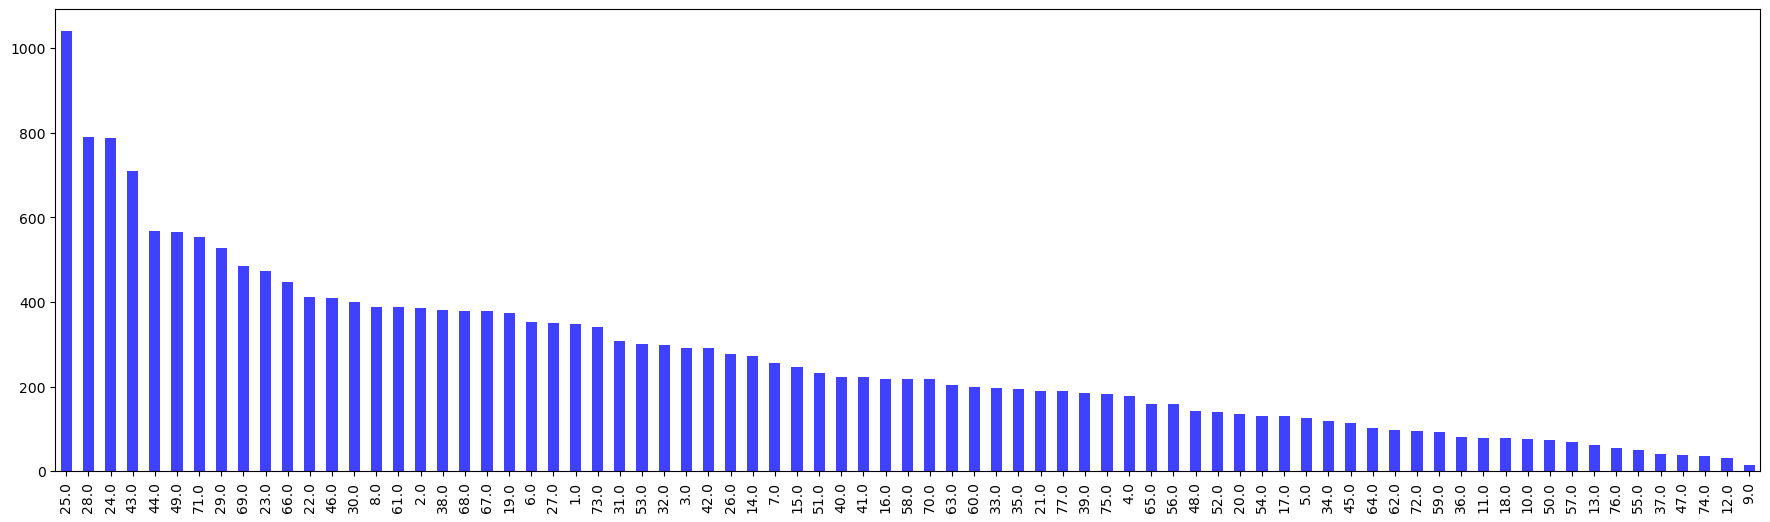

In [8]:
# Count the occurrences of each category
category_counts = train_df['cluster_num'].value_counts()

# Plotting
category_counts.plot(kind='bar', alpha=0.75, color='blue', figsize=(22, 6))

In [9]:
test_df.describe(include='all')

,x,y,cluster_num
count,5094.000000,5094.000000,5094.0
unique,NaN,NaN,77.0
top,NaN,NaN,25.0
freq,NaN,NaN,278.0
mean,41.838853,-87.668812,NaN
std,0.088203,0.058717,NaN
min,41.647716,-87.906547,NaN
25%,41.764212,-87.710435,NaN
50%,41.847612,-87.665034,NaN
75%,41.907087,-87.625856,NaN


<Axes: >

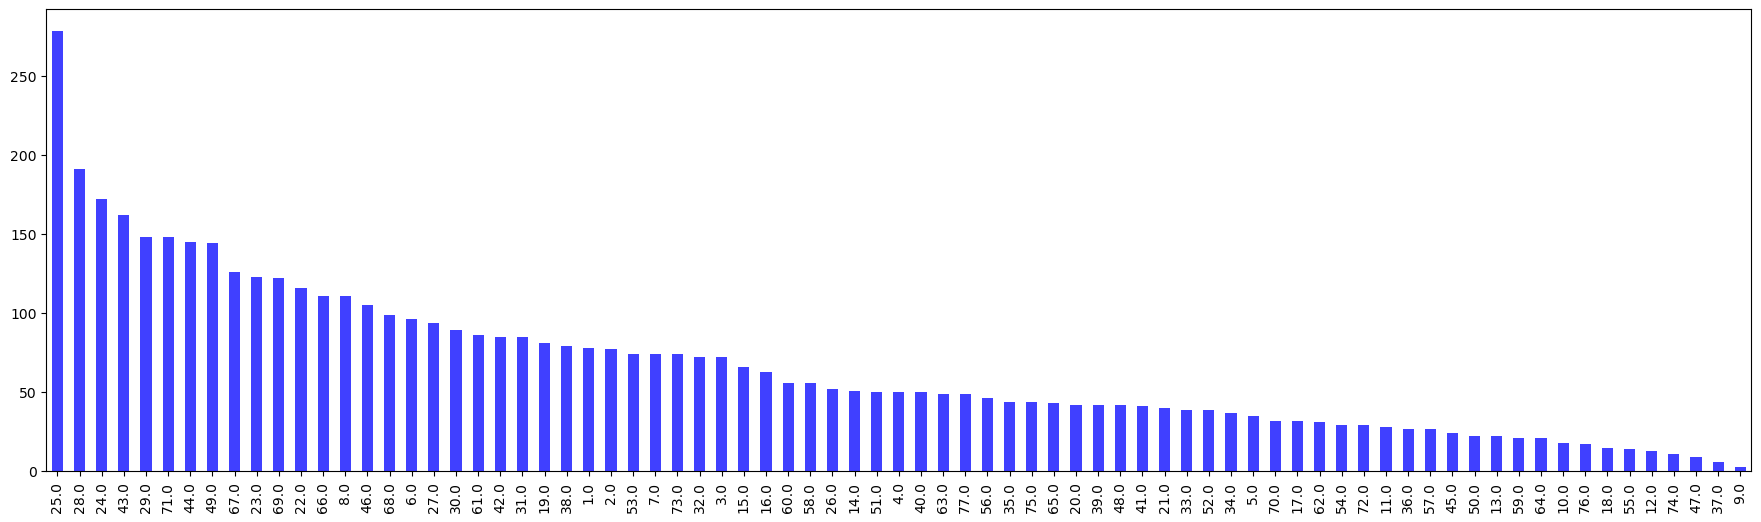

In [10]:
# Count the occurrences of each category
category_counts = test_df['cluster_num'].value_counts()

# Plotting
category_counts.plot(kind='bar', alpha=0.75, color='blue', figsize=(22, 6))

## Spatial K-Fold Cross Validation

In [12]:
# Using list comprehension
x_data_train = [inner_list[0] for inner_list in X_train_crimes]
y_data_train = [inner_list[1] for inner_list in X_train_crimes]
cluster_num_data_train = [inner_list[2] for inner_list in X_train_crimes]

In [16]:
cv_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'cluster_num':cluster_num_data_train,
    'Z': y_train_crimes
})

# Initialize an empty dictionary
cv_score_list = {}
powers_list = [1,2,3,4,5,6,7,8,9,10,11,12,15,20]

start_time = time.time()
#For each possible theoratical model, conduct K-Fold CV
for power in powers_list:
    
    
    # Define K-Fold cross-validation
    group_kfold = GroupKFold(n_splits = 10)

    # Initialize lists to store cross-validation results
    cv_scores_mae = []
    cv_scores_rmse = []
    cv_scores_mape = []
    cv_scores_r2 = []

    # Perform K-Fold cross-validation
    for train_index, test_index in group_kfold.split(cv_data['X'],cv_data['Y'],cv_data['cluster_num']):
        train_data = cv_data.iloc[train_index]
        test_data = cv_data.iloc[test_index]
        
        combined_array_train = np.array([list(pair) for pair in zip(train_data['X'], train_data['Y'])])
        idw_model = ShepardIDWInterpolator(combined_array_train, train_data['Z'])
        
        # Predict at test locations
        combined_array_test = np.array([list(pair) for pair in zip(test_data['X'], test_data['Y'])])
        z_pred_train = idw_model.__call__(combined_array_test, power = power)
        
        # Calculate Metrics and append the validation score for each split into cv_scores_metric
        rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred_train))
        mae = mean_absolute_error(test_data['Z'], z_pred_train)
        mape = mean_absolute_percentage_error(test_data['Z'], z_pred_train)
        r2 = r2_score(test_data['Z'], z_pred_train)
        
        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)
        cv_scores_mape.append(mape)
        cv_scores_r2.append(r2)
        
    # Calulcate mean CV score for all splits for each metric    
    mean_validation_score_mae = np.mean(cv_scores_mae)
    mean_validation_score_rmse = np.mean(cv_scores_rmse)
    mean_validation_score_mape = np.mean(cv_scores_mape)
    mean_validation_score_r2 = np.mean(cv_scores_r2)
    
    # Store the mean CV score for each metric for this iteration of theoratical model chosen
    cv_score_list[power] = {
        "Mean CV Score MAE" : mean_validation_score_mae,
        "Mean CV Score RMSE" : mean_validation_score_rmse,
        "Mean CV Score MAPE" : mean_validation_score_mape,
        "Mean CV Score R Squared": mean_validation_score_r2
    }

end_time = time.time()
# Now there is a dictionary of mean CV scores for 3 different metrics for each possible model 
display(pd.DataFrame(cv_score_list))

# Find the model with the smallest mean CV score for each metric
# Initialize a dictionary to track the smallest scores and corresponding models
smallest_scores = {
    "Mean CV Score MAE": {"value": float('inf'), "power": None},
    "Mean CV Score RMSE": {"value": float('inf'), "power": None},
    "Mean CV Score MAPE": {"value": float('inf'), "power": None},
    "Mean CV Score R Squared": {"value": float('-inf'), "power": None}
}
    
# Iterate through each model's scores in the dictionary
for power, scores in cv_score_list.items():
    for score_type, score_value in scores.items():
        # Special handling for R Squared to find the maximum
        if score_type == "Mean CV Score R Squared":
            if score_value > smallest_scores[score_type]["value"]:
                smallest_scores[score_type]["value"] = score_value
                smallest_scores[score_type]["power"] = power
        # For all other metrics, we find the minimum
        else:
            if score_value < smallest_scores[score_type]["value"]:
                smallest_scores[score_type]["value"] = score_value
                smallest_scores[score_type]["power"] = power

# Display the results
for score_type, info in smallest_scores.items():
    if score_type == "Mean CV Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['power']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['power']}.")
    
print(f"Training Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,15,20
Mean CV Score MAE,0.391698,0.393950,0.396665,0.399125,0.401170,0.402803,0.404066,0.405029,0.405723,0.406211,0.406557,0.406830,0.407266,0.407358
Mean CV Score RMSE,0.920824,0.933293,0.950803,0.969091,0.985866,1.000497,1.012984,1.023521,1.032382,1.039859,1.046225,1.051707,1.064479,1.078867
Mean CV Score MAPE,0.265453,0.267934,0.270562,0.272852,0.274672,0.276047,0.277051,0.277763,0.278237,0.278530,0.278693,0.278776,0.278693,0.278101
Mean CV Score R Squared,-0.272597,-0.348333,-0.455872,-0.570097,-0.674159,-0.763667,-0.839133,-0.901918,-0.953607,-0.995953,-1.030707,-1.059447,-1.121376,-1.183101


The smallest Mean CV Score MAE is 0.3916977375939891, found in power 1.
The smallest Mean CV Score RMSE is 0.9208243528570119, found in power 1.
The smallest Mean CV Score MAPE is 0.26545331009258893, found in power 1.
The largest Mean CV Score R Squared is -0.2725967028114095, found in power 1.
Training Computation Time: 13.07 seconds


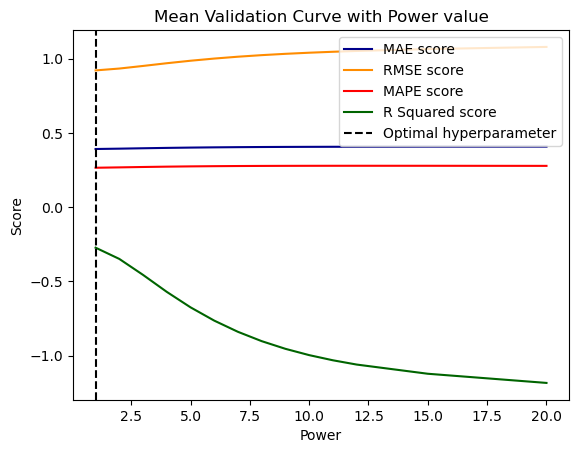

In [17]:
power = 1
df = pd.DataFrame(cv_score_list).T
plt.plot(powers_list, df["Mean CV Score MAE"], color='darkblue', label='MAE score')
plt.plot(powers_list, df["Mean CV Score RMSE"], color='darkorange', label='RMSE score')
plt.plot(powers_list, df["Mean CV Score MAPE"], color='red', label='MAPE score')
plt.plot(powers_list, df["Mean CV Score R Squared"], color='darkgreen', label='R Squared score')
plt.axvline(power, c='k', ls='--', label = "Optimal hyperparameter")

plt.xlabel('Power')
plt.ylabel('Score')
#plt.yscale('log')
plt.legend()
plt.title("Mean Validation Curve with Power value")
plt.show()

### n_neighbors

In [18]:
cv_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'cluster_num':cluster_num_data_train,
    'Z': y_train_crimes
})

# Initialize an empty dictionary
cv_score_list = {}

# For each possible number of neighbors, conduct K-Fold CV
n_neighbors_list = [8, 10, 12, 24, 48, 96, 120, 150, 180, 200, 250, 2000, 2500]

start_time = time.time()

for n_neighbors in n_neighbors_list:
    
    # Define K-Fold cross-validation
    group_kfold = GroupKFold(n_splits = 10)

    # Initialize lists to store cross-validation results
    cv_scores_mae = []
    cv_scores_rmse = []
    cv_scores_mape = []
    cv_scores_r2 = []

    # Perform K-Fold cross-validation
    for train_index, test_index in group_kfold.split(cv_data['X'],cv_data['Y'],cv_data['cluster_num']):
        train_data = cv_data.iloc[train_index]
        test_data = cv_data.iloc[test_index]
        
        combined_array_train = np.array([list(pair) for pair in zip(train_data['X'], train_data['Y'])])
        idw_model = ShepardIDWInterpolator(combined_array_train, train_data['Z'])
        
        # Predict at test locations
        combined_array_test = np.array([list(pair) for pair in zip(test_data['X'], test_data['Y'])])
        z_pred_train = idw_model.__call__(combined_array_test, power = 1, n_neighbors = n_neighbors)
        
        # Calculate Metrics
        rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred_train))
        mae = mean_absolute_error(test_data['Z'], z_pred_train)
        mape = mean_absolute_percentage_error(test_data['Z'], z_pred_train)
        r2 = r2_score(test_data['Z'], z_pred_train)
        
        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)
        cv_scores_mape.append(mape)
        cv_scores_r2.append(r2)
        
    # Calculate mean CV score for all splits for each metric    
    mean_validation_score_mae = np.mean(cv_scores_mae)
    mean_validation_score_rmse = np.mean(cv_scores_rmse)
    mean_validation_score_mape = np.mean(cv_scores_mape)
    mean_validation_score_r2 = np.mean(cv_scores_r2)
    
    
    # Store the mean CV score for each metric for this iteration of n_neighbors chosen
    cv_score_list[n_neighbors] = {
        "Mean CV Score MAE": mean_validation_score_mae,
        "Mean CV Score RMSE": mean_validation_score_rmse,
        "Mean CV Score MAPE": mean_validation_score_mape,
        "Mean CV Score R Squared": mean_validation_score_r2
    }
end_time = time.time()

# Display the results
display(pd.DataFrame(cv_score_list))  # Transposed for better readability

# Find the model with the smallest mean CV score for each metric
# Adjusted to find the best `n_neighbors`    
smallest_scores = {
    "Mean CV Score MAE": {"value": float('inf'), "model": None},
    "Mean CV Score RMSE": {"value": float('inf'), "model": None},
    "Mean CV Score MAPE": {"value": float('inf'), "model": None},
    "Mean CV Score R Squared": {"value": float('-inf'), "model": None} # Changed to '-inf' for maximization
}

# Iterate through each model's scores in the dictionary
for n_neighbors, scores in cv_score_list.items():
    for score_type, score_value in scores.items():
        # Special handling for R Squared to find the maximum
        if score_type == "Mean CV Score R Squared":
            if score_value > smallest_scores[score_type]["value"]:
                smallest_scores[score_type]["value"] = score_value
                smallest_scores[score_type]["n_neighbors"] = n_neighbors
        # For all other metrics, we find the minimum
        else:
            if score_value < smallest_scores[score_type]["value"]:
                smallest_scores[score_type]["value"] = score_value
                smallest_scores[score_type]["n_neighbors"] = n_neighbors

# Display the results
for score_type, info in smallest_scores.items():
    if score_type == "Mean CV Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['n_neighbors']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['n_neighbors']}.")
        
print(f"Training Computation Time: {end_time - start_time:.2f} seconds")

,8,10,12,24,48,96,120,150,180,200,250,2000,2500
Mean CV Score MAE,0.391698,0.389798,0.387779,0.378664,0.372100,0.368884,0.368427,0.367449,0.366840,0.366621,0.366525,0.367572,0.367273
Mean CV Score RMSE,0.920824,0.906299,0.898441,0.873387,0.860347,0.853504,0.852504,0.851667,0.851219,0.850843,0.850288,0.850184,0.850355
Mean CV Score MAPE,0.265453,0.264205,0.262620,0.253674,0.246630,0.243109,0.242584,0.241564,0.240800,0.240503,0.240333,0.239699,0.239155
Mean CV Score R Squared,-0.272597,-0.216001,-0.194126,-0.086859,-0.033396,-0.008080,-0.003763,-0.000491,0.001646,0.003014,0.005092,0.007443,0.007341


The smallest Mean CV Score MAE is 0.36652525757585813, found in n_neighbors 250.
The smallest Mean CV Score RMSE is 0.8501844831100058, found in n_neighbors 2000.
The smallest Mean CV Score MAPE is 0.23915545654961762, found in n_neighbors 2500.
The largest Mean CV Score R Squared is 0.007443470265485919, found in n_neighbors 2000.
Training Computation Time: 23.26 seconds


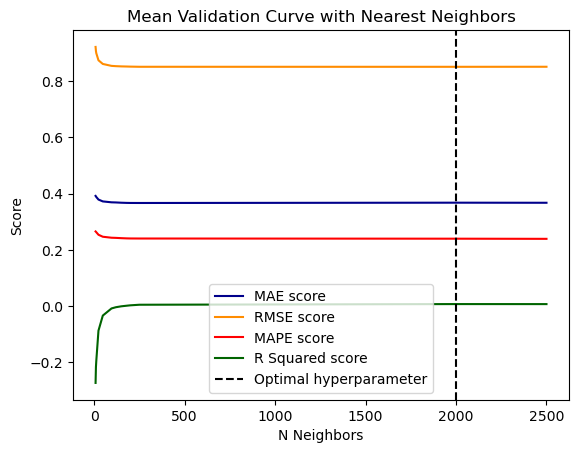

In [19]:
n_neighbors = 2000
df = pd.DataFrame(cv_score_list).T
plt.plot(n_neighbors_list, df["Mean CV Score MAE"], color='darkblue', label='MAE score')
plt.plot(n_neighbors_list, df["Mean CV Score RMSE"], color='darkorange', label='RMSE score')
plt.plot(n_neighbors_list, df["Mean CV Score MAPE"], color='red', label='MAPE score')
plt.plot(n_neighbors_list, df["Mean CV Score R Squared"], color='darkgreen', label='R Squared score')
plt.axvline(n_neighbors, c='k', ls='--', label = "Optimal hyperparameter")

plt.xlabel('N Neighbors')
plt.ylabel('Score')
#plt.yscale('log')
plt.legend()
plt.title("Mean Validation Curve with Nearest Neighbors")
plt.show()

We can see that RMSE and MAPE do not seem to be robust metrics here, and thus the hyperparameter is chosen based on MAE.

## Hyperparameter selection

As we can see, power = 1 and n_neighbors = 2500 would be the most optimal option.

## Evaluation of Model (Testing Chosen model)

### Performance Metrics of Model

In [20]:
# Using list comprehension
x_data_train = [inner_list[0] for inner_list in X_train_crimes]
y_data_train = [inner_list[1] for inner_list in X_train_crimes]

train_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'Z': y_train_crimes
})

x_data_test = [inner_list[0] for inner_list in X_test_crimes]
y_data_test = [inner_list[1] for inner_list in X_test_crimes]

test_data = pd.DataFrame({
    'X': x_data_test,
    'Y': y_data_test,
    'Z': y_test_crimes
})

eval_combined_array_coordinates = np.array([list(pair) for pair in zip(train_data['X'], train_data['Y'])])

start_time = time.time()
idw_model = ShepardIDWInterpolator(eval_combined_array_coordinates, train_data['Z'])

 # Predict at test locations
eval_combined_array_test = np.array([list(pair) for pair in zip(test_data['X'], test_data['Y'])])
z_pred_test = idw_model.__call__(eval_combined_array_test, power = 1, n_neighbors = 12)

rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred_test))
mae = mean_absolute_error(test_data['Z'], z_pred_test)
mape = mean_absolute_percentage_error(test_data['Z'], z_pred_test)
r2 = r2_score(test_data['Z'], z_pred_test)

end_time = time.time()

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R Squared:", r2)
print(f"Testing Computation Time: {end_time - start_time:.2f} seconds")

MAE: 0.3618557844051834
RMSE: 0.9559916426349692
MAPE: 0.23261235686681303
R Squared: -0.07669267569923055
Testing Computation Time: 0.12 seconds


### Plotting Spatial Interpolation of entire area with Model

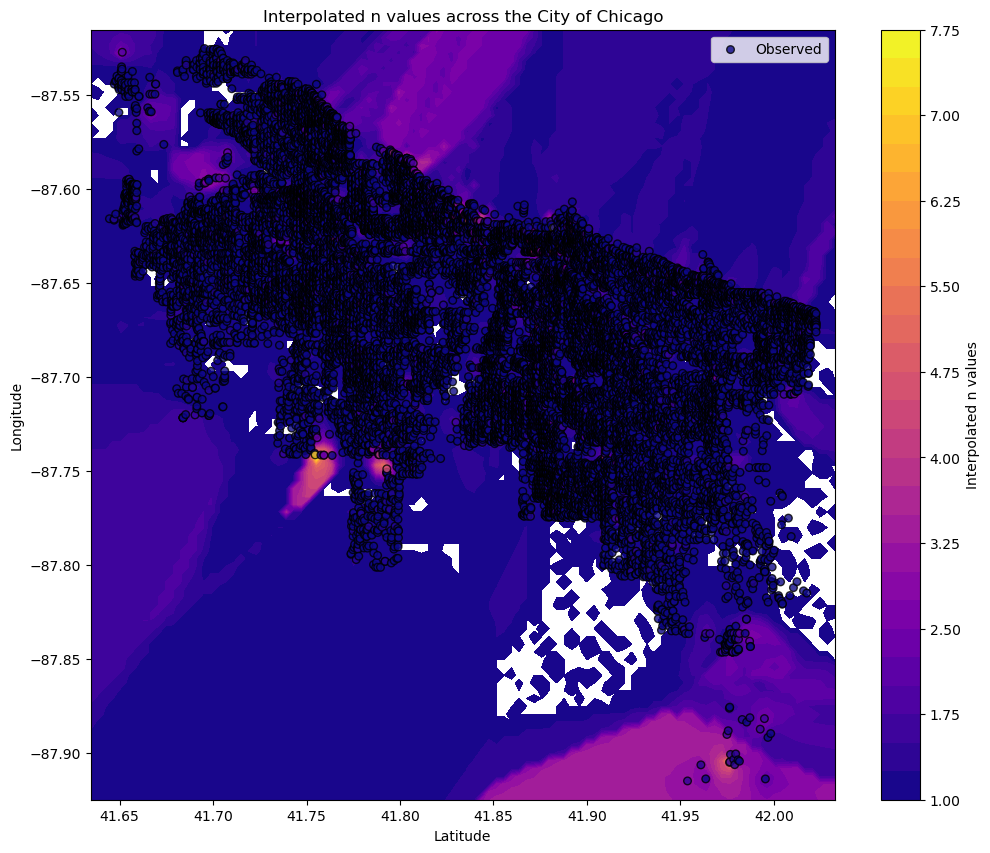

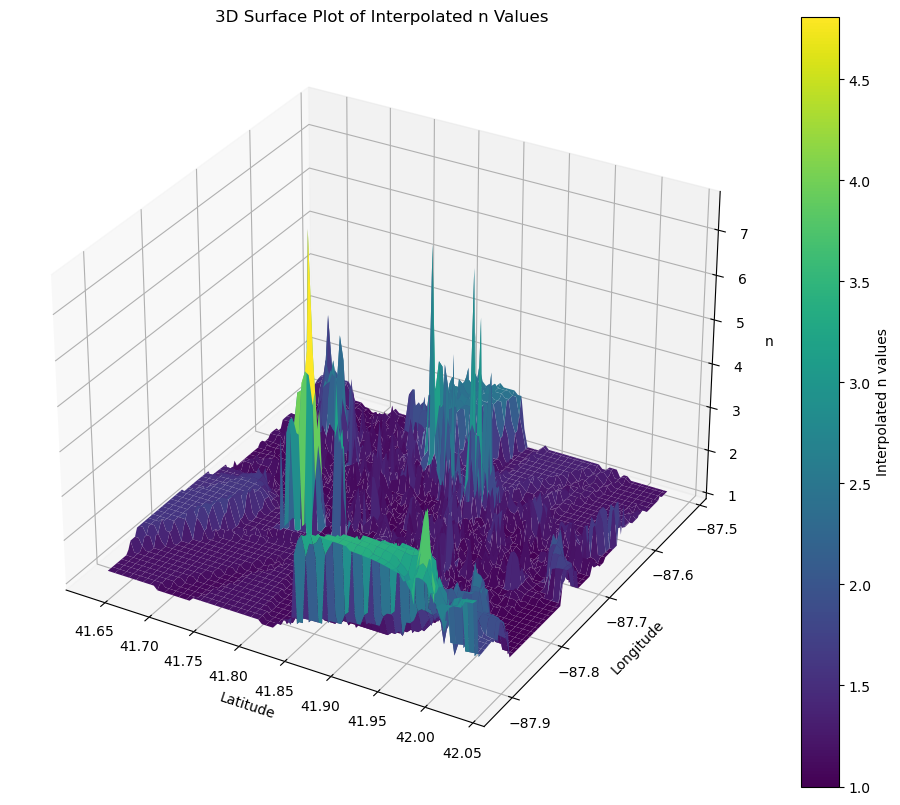

Spatial Interpolation Computation Time: 0.33 seconds


In [23]:
# Using full set: Convert columns to numpy arrays
observed_location_columns_crimes = ['Latitude', 'Longitude']
observed_values_column_crimes = 'n'
observed_locations_crimes = crimes_df[observed_location_columns_crimes].values
observed_values_crimes = crimes_df[observed_values_column_crimes].values

# Initialize IDW model
idw_model = ShepardIDWInterpolator(observed_locations_crimes, observed_values_crimes)

buffer = 0.01
x_min, x_max = observed_locations_crimes[:, 0].min() - buffer, observed_locations_crimes[:, 0].max() + buffer
y_min, y_max = observed_locations_crimes[:, 1].min() - buffer, observed_locations_crimes[:, 1].max() + buffer

x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Start timing spatial interpolation
start_time_interpolation = time.time()

# Interpolate values
#predictions = idw_model.__call__(observed_locations_crimes, power = 1, n_neighbors = 12)
interpolated_values = idw_model.__call__(grid_points, power = 1, n_neighbors = 12)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

fig = plt.figure(figsize=(12, 10))

from mpl_toolkits.mplot3d import Axes3D

plt.contourf(x_grid, y_grid, z_grid, cmap='plasma', levels=30)
plt.colorbar(label='Interpolated n values')
plt.scatter(crimes_df['Latitude'],crimes_df['Longitude'], c=crimes_df['n'], cmap='plasma', edgecolor='k', label='Observed', marker='o', s=30, alpha=0.8)

plt.xlim(x_min, x_max)  # Set x-axis limits
plt.ylim(y_min, y_max)  # Set y-axis limits

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.title('Interpolated n values across the City of Chicago')
plt.show()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', edgecolor='none')
fig.colorbar(surf, ax=ax, label='Interpolated n values')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('n')
ax.set_title('3D Surface Plot of Interpolated n Values')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")

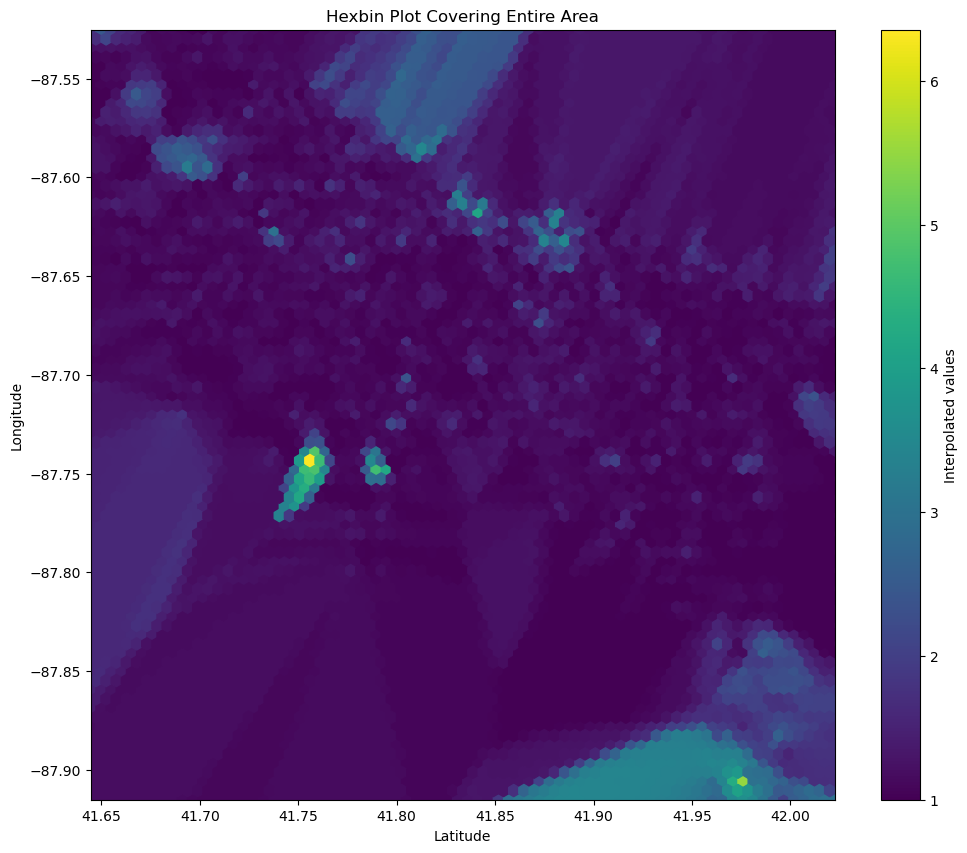

Spatial Interpolation Computation Time: 1.15 seconds


In [24]:
# Determine the minimum and maximum values for Latitude and Longitude
lat_min, lat_max = crimes_df['Latitude'].min(), crimes_df['Latitude'].max()
lon_min, lon_max = crimes_df['Longitude'].min(), crimes_df['Longitude'].max()

# Generate a mesh grid of latitude and longitude values
grid_size = 200  # Square root of num_points, adjust as needed for resolution
latitude_range = np.linspace(lat_min, lat_max, grid_size)
longitude_range = np.linspace(lon_min, lon_max, grid_size)
lat_grid, lon_grid = np.meshgrid(latitude_range, longitude_range)

# Flatten the grid to create combined array of [latitude, longitude] pairs
combined_array = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))

# Start timing spatial interpolation
start_time_interpolation = time.time()
# Simulate interpolated_values from your IDW model or similar
interpolated_values = idw_model(combined_array, power=1, n_neighbors=12)

end_time_interpolation = time.time()  # End timing spatial interpolation
# Plot using hexbin
plt.figure(figsize=(12, 10))
hb = plt.hexbin(combined_array[:, 0], combined_array[:, 1], C=interpolated_values, gridsize=73, cmap='viridis', extent=(lat_min, lat_max, lon_min, lon_max))
plt.colorbar(hb, label='Interpolated values')

plt.xlim(lat_min, lat_max)
plt.ylim(lon_min, lon_max)

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Hexbin Plot Covering Entire Area')
plt.show()
print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")